In [1]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
import dotenv
from langchain_openai import OpenAIEmbeddings

dotenv.load_dotenv()
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

pc =Pinecone()

index_name = "tax-index-langgraph"

index = pc.Index(index_name)
vectorstore = PineconeVectorStore(embedding=embedding, index=index)


retriever = vectorstore.as_retriever(search_kwargs={'k':3})

C:\Users\soobi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [4]:
from langsmith import Client

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
 
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.

In [5]:
def retrieve(state: AgentState) -> AgentState:
   
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [6]:
from langsmith import Client
from typing import Literal

client = Client()
relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    
    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
   
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    
    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state를 반환합니다.

In [8]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [10]:
graph = graph_builder.compile()

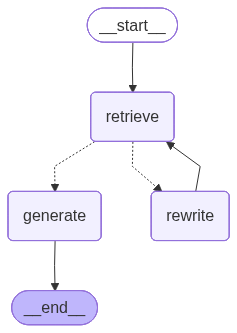

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

{'query': '거주자의 연봉 5천만 원에 대한 세금은 어떻게 계산되나요?',
 'context': [Document(id='8652685f-339a-4763-b6e4-8f5a7194693b', metadata={'source': './tax_combined_final.txt'}, page_content='종합소득\n과세표준\n세율\n1,400만원 이하\n과세표준의 6퍼센트\n1,400만원 초과\n84만원 + (1,400만원을 초과하는 금액의 15퍼센트)\n5,000만원 이하\n5,000만원 초과\n624만원 + (5,000만원을 초과하는 금액의 24퍼센트)\n8,800만원 이하\n8,800만원 초과\n1,536만원 + (8,800만원을 초과하는 금액의 35퍼센트)\n1억5천만원 이하\n1억5천만원 초과\n3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)\n3억원 이하\n3억원 초과\n9,406만원 + (3억원을 초과하는 금액의 40퍼센트)\n5억원 이하\n5억원 초과\n1억7,406만원 + (5억원을 초과하는 금액의 42퍼센트)\n10억원 이하\n10억원 초과\n3억8,406만원 + (10억원을 초과하는 금액의 45퍼센트)\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다. <개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제 <2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n제2관 세액공제 <개정 2009. 12. 31.>\n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 더한 금액에 해당하는 금액을 종합소득 산출세액에서 공제한다. <개정